In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
processed_news_file_path = '../../data/news/nasdaq_news_data_processed.csv'

print(f"Loading processed news data from {processed_news_file_path}...")
news_df = pd.read_csv(processed_news_file_path, parse_dates=['Date'])
print(f"Loaded {len(news_df)} news items.")


Loading processed news data from ../../data/news/nasdaq_news_data_processed.csv...
Loaded 209125 news items.


In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209125 entries, 0 to 209124
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   UID      209125 non-null  int64         
 1   Date     209125 non-null  datetime64[ns]
 2   Ticker   209125 non-null  object        
 3   Title    209125 non-null  object        
 4   Summary  209125 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.0+ MB


In [8]:
news_df.isnull().sum()

UID        0
Date       0
Ticker     0
Title      0
Summary    0
dtype: int64

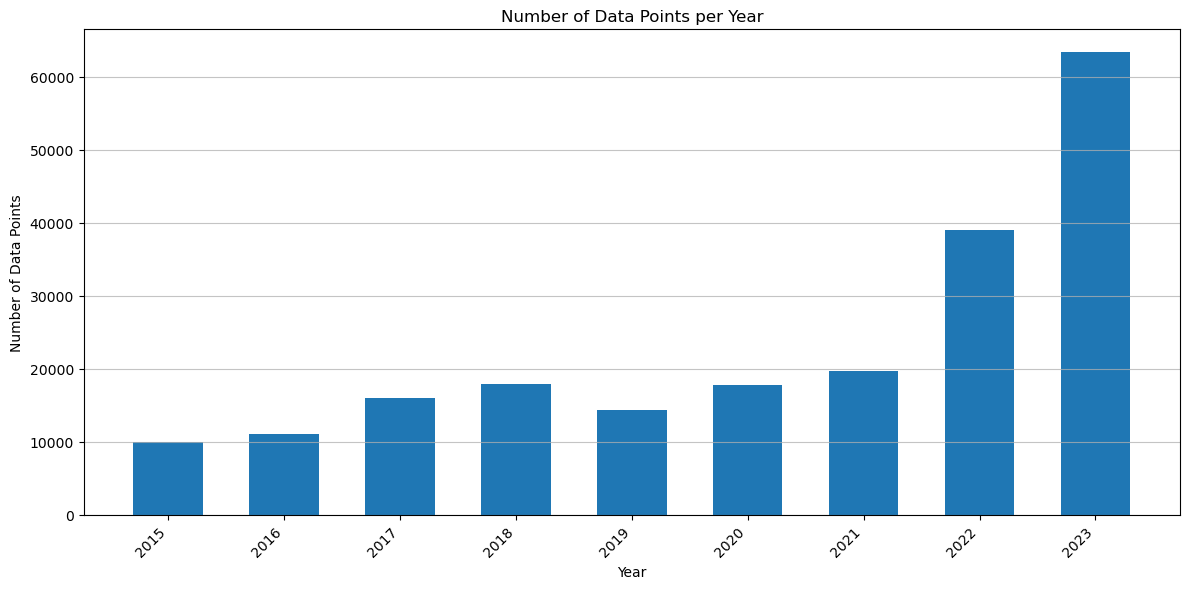

In [10]:
def plot_yearly_data_bar_chart(data, date_column):
    """
    Plots a bar chart showing the exact number of data points per year.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        date_column (str): The name of the column containing the dates.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_copy = data.copy()

    # Convert the date column to datetime objects if not already
    df_copy[date_column] = pd.to_datetime(df_copy[date_column], errors='coerce')

    # Drop rows where date conversion failed
    df_copy.dropna(subset=[date_column], inplace=True)

    # --- Group by Year using .dt.year ---
    # Extract year directly
    df_copy['Year'] = df_copy[date_column].dt.year

    # Group by the extracted year and count occurrences
    yearly_counts = df_copy.groupby('Year').size()

    # --- Create the Bar Chart ---
    plt.figure(figsize=(12, 6)) # Adjust figure size as needed

    # Use the year index directly for plotting
    plt.bar(yearly_counts.index, yearly_counts.values, width=0.6) # Adjust width if needed

    # --- Customize the Plot ---
    plt.title('Number of Data Points per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Data Points')
    plt.grid(axis='y', alpha=0.75)

    # --- Format X-axis ---
    # Ensure x-axis ticks are integers representing the years
    plt.xticks(yearly_counts.index, rotation=45, ha='right')
    # Optional: Force integer ticks if years are skipped
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))


    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # Show the plot
    plt.show()
    
plot_yearly_data_bar_chart(news_df, 'Date')

In [11]:
text_columns = [
    'Title',
    'Summary'
]

print("Calculating average word counts...")

# Dictionary to store average word counts
average_word_counts = {}

# Iterate through the specified columns
for col in text_columns:
    if col in news_df.columns:
        # Calculate word count for each entry in the column
        # Convert to string to handle potential NaNs or non-string types, then split and get length
        word_counts = news_df[col].astype(str).apply(lambda x: len(x.split()))

        # Calculate the average word count
        average_wc = word_counts.mean()
        average_word_counts[col] = average_wc
        print(f" - Average word count for '{col}': {average_wc:.2f}")
    else:
        print(f" - Warning: Column '{col}' not found in DataFrame.")


Calculating average word counts...
 - Average word count for 'Title': 9.63
 - Average word count for 'Summary': 83.24


In [12]:
def analyze_daily_unique_tickers_per_year(df, date_column, ticker_column):
    """
    Calculates the average number of unique tickers with news per day, for each year.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing the dates.
        ticker_column (str): The name of the column containing the tickers.

    Returns:
        dict: A dictionary where keys are the years (int) and values are the
              average number of unique tickers appearing per day in that year.
              Returns None if a critical error occurs, or an empty dict if no valid data.
    """
    if not isinstance(df, pd.DataFrame):
        print("Error: Input is not a pandas DataFrame.")
        return None
    if date_column not in df.columns:
        print(f"Error: Date column '{date_column}' not found in DataFrame.")
        return None
    if ticker_column not in df.columns:
        print(f"Error: Ticker column '{ticker_column}' not found in DataFrame.")
        return None

    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    # Convert the date column to datetime objects, coercing errors
    df_copy[date_column] = pd.to_datetime(df_copy[date_column], errors='coerce')

    # Drop rows where date conversion failed or ticker is missing
    initial_rows = len(df_copy)
    df_copy.dropna(subset=[date_column, ticker_column], inplace=True)
    dropped_rows = initial_rows - len(df_copy)
    if dropped_rows > 0:
        print(f"Warning: Dropped {dropped_rows} rows with invalid dates or missing tickers.")

    if df_copy.empty:
        print("DataFrame is empty after handling invalid dates/tickers.")
        return {}

    # Extract year and date
    df_copy['Year'] = df_copy[date_column].dt.year
    df_copy['DateOnly'] = df_copy[date_column].dt.date

    # --- Calculate Number of Unique Tickers Per Day ---
    # Group by Year and DateOnly, then count the number of unique tickers within each day's group.
    unique_tickers_per_day = df_copy.groupby(['Year', 'DateOnly'])[ticker_column].nunique()

    if unique_tickers_per_day.empty:
        print("No valid data found to group by Year and Date.")
        return {}

    # --- Calculate the Average of Daily Unique Ticker Counts per Year ---
    # Group the daily unique counts by Year and calculate the mean.
    avg_unique_tickers_per_day_by_year = unique_tickers_per_day.groupby('Year').mean()

    yearly_results = {}
    print("\n--- Average Unique Tickers Per Day By Year ---")
    for year, avg_count in avg_unique_tickers_per_day_by_year.items():
        yearly_results[year] = avg_count
        print(f"  Year {year}: {avg_count:.2f} unique tickers per day (on average)")

    return yearly_results


yearly_unique_ticker_analysis = analyze_daily_unique_tickers_per_year(news_df, 'Date', 'Ticker')





--- Average Unique Tickers Per Day By Year ---
  Year 2015: 15.73 unique tickers per day (on average)
  Year 2016: 17.16 unique tickers per day (on average)
  Year 2017: 19.41 unique tickers per day (on average)
  Year 2018: 21.68 unique tickers per day (on average)
  Year 2019: 19.31 unique tickers per day (on average)
  Year 2020: 21.16 unique tickers per day (on average)
  Year 2021: 24.61 unique tickers per day (on average)
  Year 2022: 34.31 unique tickers per day (on average)
  Year 2023: 39.05 unique tickers per day (on average)
